In [130]:
from sklearn.externals.joblib import Memory
from sklearn.datasets import load_svmlight_file
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import linear_model
import matplotlib.pyplot as plt
%matplotlib inline

In [131]:
# 加载数据
mem = Memory("./mycache")
@mem.cache
def get_data():
    data = load_svmlight_file("../data/australian_scale")
    return data[0],data[1]

X,y = get_data()
N,D = X.shape
print(N,D)
print(type(X))
C = len(set(y))
y = np.where(y>0,1,0).reshape(-1,1)
# print(y)

690 14
<class 'scipy.sparse.csr.csr_matrix'>


In [132]:
# 分割训练集和验证集
X_train,X_val,y_train,y_val = train_test_split(X,y,test_size=0.4)
X_train = X_train.toarray()
X_val = X_val.toarray()
y_train = y_train.reshape(-1,1)
y_val = y_val.reshape(-1,1)
print(X_train[0])
print(y_train[0])

[ 1.       -0.922406 -0.803571  0.       -0.230769 -0.25     -0.953333 -1.
  1.       -0.970149 -1.        0.       -0.92     -0.99958 ]
[0]


In [133]:
def svm_loss(W, X, y, reg):
  
    loss = 0.0
#     初始化梯度导数为０
    dW = np.zeros(W.shape) 

    N = X.shape[0]
    #scores = np.dot(X, W)
    #margin = scores - scores[range(0, N), y].reshape(N, 1) + 1
    #margin[range(0, N), y] = 0
    #margin = margin * (margin > 0) # max(0, s_j - s_yi + delta)
    #loss += np.sum(margin) / N + 0.5 * reg * np.sum(W * W)
    scores = X.dot(W) # N x C
    
    margin = scores - scores[range(0,N), y.reshape(1,-1)].reshape(-1,1) + 1 # N x C
    margin[range(N), y.reshape(1,-1)] = 0
    margin = (margin > 0) * margin
    loss += margin.sum() / N
    loss += 0.5 * reg * np.sum(W * W)

    counts = (margin > 0).astype(int)
    counts[range(N), y] = - np.sum(counts, axis = 1)
    dW += np.dot(X.T, counts) / N + reg * W

    return loss, dW

In [134]:
def train(X_train,y_train=None,w=None,reg=None,lr=None):
    N,D = X_train.shape
    if w is None:
        w = 0.001 * np.random.randn(D, C)
    loss, dW = svm_loss(w,X_train,y_train,reg)
    w += -lr * dW
    return {'w':w,'loss':loss}

In [135]:
def val(X_val,y_val,w,reg):
    N,D = X_val.shape
    loss, dW = svm_loss(w,X_train,y_train,reg)
    return {'loss':loss}

In [136]:
# 正则参数和学习率
reg_list = np.logspace(-4,1,num=6,base=10)
#reg_list = [0]
lr_list = np.logspace(-4,1,num=6,base=10)
#lr_list = [1e-2]

min_loss = 1000
best_reg = None
best_lr = None
best_w = None
best_train_loss_hist = None
best_val_loss_hist = None
# 尝试不同的正则参数和学习率
for reg in reg_list:
    for lr in lr_list:
        train_loss_hist = []
        val_loss_hist = []
        w = None
        
        for i in range(50):
            train_res = train(X_train,y_train,w=w,reg=reg,lr=lr)
            w = train_res['w']
            train_loss_hist.append(train_res['loss'])
            
            val_res = val(X_val,y_val,w,reg=reg)
            val_loss_hist.append(val_res['loss'])

        cur_loss = val_loss_hist[-1]
#         print('-'*100)
#         print('loss:{},lr:{},reg:{}'.format(cur_loss,lr,reg))
        if cur_loss is not None and cur_loss < min_loss:
            min_loss = cur_loss
            best_lr = lr
            best_reg = reg
            best_w = w
            best_train_loss_hist = train_loss_hist
            best_val_loss_hist = val_loss_hist
            
print('*'*100)
print('min train loss:{},lr:{},reg:{}'.format(min_loss,best_lr,best_reg))

****************************************************************************************************
min train loss:0.9982836554931929,lr:0.001,reg:0.0001


best w:[[ 0.01843037  0.01857472]
 [-0.02247739 -0.02267466]
 [-0.0342483  -0.03291605]
 [-0.01269587 -0.01203555]
 [-0.00254217  0.00070499]
 [-0.0038142  -0.0024106 ]
 [-0.04254086 -0.04071006]
 [ 0.00340893  0.00498882]
 [-0.00396145 -0.00520171]
 [-0.04638145 -0.04680527]
 [-0.00558793 -0.00705837]
 [-0.00203918 -0.00347814]
 [-0.03989907 -0.04246105]
 [-0.0501927  -0.04907838]] 
best_lr:0.001 
best_reg:0.0001
avg_train_loss:0.998282956962299,avg_val_loss:0.9982829777110499


Text(0.5,1,'loss')

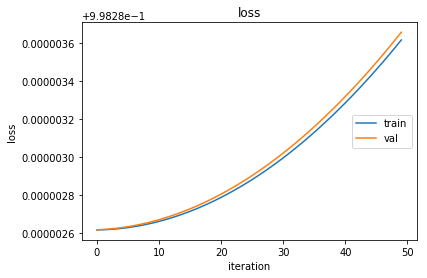

In [137]:
print('best w:{} \nbest_lr:{} \nbest_reg:{}'.format(best_w,best_lr,best_reg))
print('avg_train_loss:{},avg_val_loss:{}'.format(np.mean(best_train_loss_hist),np.mean(best_val_loss_hist)))

# plt.rcParams['figure.figsize'] = (10.0, 20.0)

# plt.subplot(3,1,1)
plt.plot(best_train_loss_hist[:])
plt.plot(best_val_loss_hist[:])
plt.xlabel('iteration')  
plt.ylabel('loss')  
plt.legend(['train','val'],loc='right')
plt.title('loss')
